In [1]:
%run ./tools.ipynb
import pandas as pd
np.set_printoptions(suppress=True)

In [2]:
month_strings = []
for i in range(1,13): month_strings.append(short_name_of_month(i))

In [3]:
mode = 'N'
top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/'
mod_dir = top_dir + 'CO2-2018/nd51/'
monthly_adjustment = []

In [42]:
mod_err = 1.
prior_err = 0.5 # PgC/month/region, prior uncertainty, to make prior error covariance matrix
adjust_matrix = np.zeros((12,22))
updated_err = np.zeros((12,22)) # updated variance

for imonth in range(1,13):

    name_month = short_name_of_month(imonth)
    ens_dir = top_dir + 'CO2-2018-' + month_string(imonth) + '/nd51/'
    
    if mode == 'N':
        delta_y0_file = 'delta_y0_model_N_' + str(imonth) + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
    else:
        delta_y0_file = 'delta_y0_model_' + str(imonth) + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'
    # open datasets
    # ensemble runs
    ds_delta_y0 = xr.open_dataset(ens_dir + delta_y0_file)
    varnames = list(ds_delta_y0.data_vars.keys())  # list of variable name
    needed_vars = [i for i in varnames if i.startswith('X_SpeciesConc_CO2Tag')] # species var names
    # one-year run
    ds_xco2 = xr.open_dataset(mod_dir + xco2_file)
    xco2_oco2  = ds_xco2['xco2_oco2']
    xco2_model = ds_xco2['xco2_model']
    xco2_error = ds_xco2['xco2_error']
    diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
    # reduce the size of all arrays and matrices, from 400k to <10k
    x = xco2_oco2.copy()
    x = x[np.logical_not(np.isnan(x))]
    ind = x.record.values   # index for slicing
    length = len(ind)
    # get a slice of arrays
    diff_slice = diff[ind].values            # [nobs], 1-3k per month
    xco2_error_slice = xco2_error[ind].values

    
    if imonth == 1:
        del_X_f = np.zeros((22,22)) # prior error covariance
        for idiag in range(22): del_X_f[idiag,idiag] = prior_err
        # delta y0
        updated_err[imonth-1,:] = np.diag(del_X_f)
        del_Y = np.empty((length,22))   # [nobs, nx]
        del_Y[:] = np.nan
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag] = ds_delta_y0[ivar][ind].values
        #del_Y = np.dot(del_Y, del_X_f) ## new line
        # observation error
        obs_error = np.zeros((length,length))  # [nobs,nobs], diagonally store obs error
        for idiag in range(length):
            #obs_error[idiag, idiag] = mes_err**2 + mod_err**2  # 2.5**2! 2.5 is too large, first error < 1 
            obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + mod_err**2  # 2.5**2! 2.5 is too large, first error < 1 
            # measurment error from oco2
            # model error and representation error = 2.5 for land
        # calculation of first posterior
        del_Y_tran = np.matrix.transpose(del_Y)     # del_y transpose [nx,nobs]
        first      = np.matmul(del_Y,del_Y_tran)    # del_y dot del_y_tran [nobs,nobs]
        second     = np.linalg.inv(first+obs_error) # (Y*Yt + R)^-1 [nobs,nobs]
        third      = np.matmul(del_Y_tran,second)   # Yt*(Y*Yt + R)^-1 [nx,nobs]
        k_e        = np.matmul(del_X_f,third)       # kalman gain, k_e = X_f*Yt*(Y*Yt + R)^-1 [ne,nobs]
        adjust     = np.matmul(k_e, diff_slice)     # adjustment to prior, k_e*(yobs - ym)  [ne]
        print('mean of yobs-ym:', "{:.2f}".format(np.mean(diff_slice)))
        print(short_name_of_month(imonth), 'adjustment: {:.2f}'.format(sum(adjust)))
        # update Y matrix
        tmp = np.dot(del_Y,adjust) # [nobs], ppm
        #diff_new = tmp + diff_slice
        print('Y update max and min:', np.amax(tmp), np.amin(tmp))
        monthly_adjustment.append(sum(adjust))
        adjust_matrix[imonth-1,:] = adjust
        # transformation matrix to use next
        fourth = np.identity(22) - np.matmul(third, del_Y)
        transform_mat = sp.sqrtm(fourth)
        
        del_X_a = np.matmul(del_X_f, transform_mat)
        del_X_f = del_X_a.copy()
        
    else:
        
        #for idiag in range(22): del_X_f[idiag,idiag] = monthly_net_flux[imonth-1,idiag]
        updated_err[imonth-1,:] = np.diag(del_X_f)
        #del_X_f_inv = np.linalg.inv(del_X_f)
        #update = np.matmul(del_X_f_inv, del_X_f)
        # delta y0
        del_Y = np.empty((length,22))
        del_Y[:] = np.nan
        
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag] = ds_delta_y0[ivar][ind].values
        #print('del_Y: ', del_Y)
        #cx = plt.cm.jet
        #plt.pcolormesh(del_Y, cmap = cx)
        #plt.colorbar()
        #plt.show()
        #del_Y = np.dot(del_Y, del_X_f)
        # observation error
        obs_error = np.zeros((length,length))
        for idiag in range(length):
            obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + mod_err**2
            #obs_error[idiag, idiag] = mes_err**2 + mod_err**2
            # measurment error from oco2
            # model error and representation error = 2.5 for land
        
        # calculation of posterior
        del_Y_tran = np.matrix.transpose(del_Y)
        first      = np.matmul(del_Y,del_Y_tran)
        second     = np.linalg.inv(first+obs_error)
        third      = np.matmul(del_Y_tran,second)
        k_e        = np.matmul(del_X_f,third)    # kalman gain,
        adjust     = np.matmul(k_e, diff_slice)  # adjustment to prior
        print('mean of yobs-ym:', "{:.2f}".format(np.mean(diff_slice)))
        print(short_name_of_month(imonth), 'adjustment: {:.2f}'.format(sum(adjust)))
        monthly_adjustment.append(sum(adjust))
        adjust_matrix[imonth-1,:] = adjust
        # update Y matrix
        tmp = np.dot(del_Y,adjust) # [nobs], ppm
        #diff_new = tmp + diff_slice
        print('Y update max and min:', np.amax(tmp), np.amin(tmp))
        # transformation matrix to use in next cycle
        fourth = np.identity(22) - np.matmul(third, del_Y)
        transform_mat = sp.sqrtm(fourth)
        
        del_X_a = np.matmul(del_X_f, transform_mat)
        del_X_f = del_X_a.copy()
        

mean of yobs-ym: -0.67
Jan adjustment: -7.93
Y update max and min: 2.197718754543203 -2.699147845880042
mean of yobs-ym: -0.94
Feb adjustment: -4.59
Y update max and min: 0.33793570764011904 -1.3996624908240658
mean of yobs-ym: -0.55
Mar adjustment: -1.42
Y update max and min: 0.28902281083959286 -1.4760551326139726
mean of yobs-ym: -0.13
Apr adjustment: -0.87
Y update max and min: 0.19249980842876807 -0.5537509356942123
mean of yobs-ym: 0.73
May adjustment: 1.00
Y update max and min: 0.46055716125051843 -0.24533625219413885
mean of yobs-ym: 1.88
Jun adjustment: 3.34
Y update max and min: 1.0210098709978304 -0.5376529886636039
mean of yobs-ym: 2.17
Jul adjustment: 3.58
Y update max and min: 0.381883852924652 -0.4025452915764378
mean of yobs-ym: 1.40
Aug adjustment: 1.16
Y update max and min: 0.2100483453544246 -0.09111178089936219
mean of yobs-ym: 1.44
Sep adjustment: 1.18
Y update max and min: 0.0813885000729453 -0.10029566733421948
mean of yobs-ym: 1.38
Oct adjustment: 1.67
Y update 

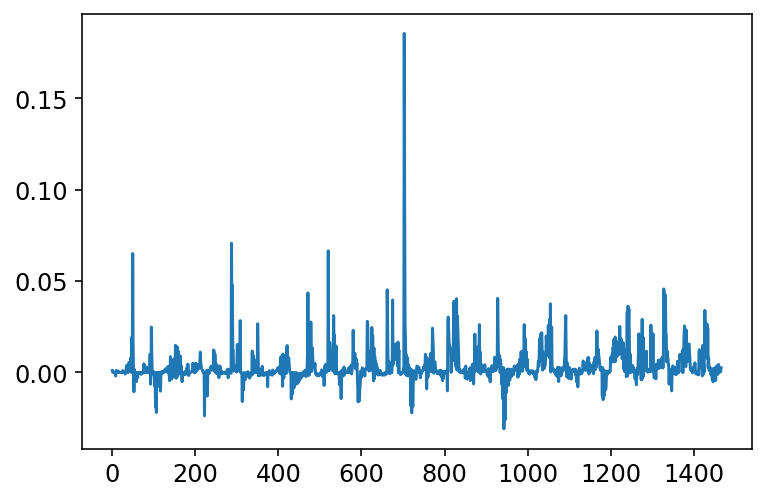

In [36]:
tmp = np.dot(del_Y,adjust) # [nobs], ppm
diff_new = tmp + diff_slice
#plt.plot(diff_slice)
plt.plot(diff_new - diff_slice)

(22, 1467)

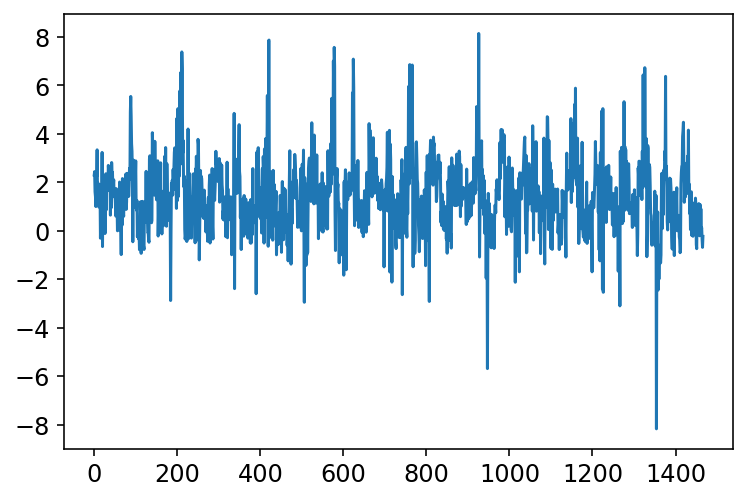

In [37]:
plt.plot(diff_slice)
diff_new = np.dot(third, diff_slice)
#plt.plot(diff_new)
np.shape(k_e)

In [43]:
monthly_net_flux = np.array([[-0.0064147 ,  0.07445906, -0.10581314,  0.02305773,  0.23837679,
         0.26386957,  0.22911544,  0.07728346,  0.09897539,  0.28756375,
         0.36633632,  0.15041014,  0.12210651, -0.11564749,  0.01955141,
        -0.0105203 ,  0.63860122,  0.03680348,  0.14569273,  0.04243613,
         0.59434582,  0.12670701],
       [ 0.04448958,  0.00888961, -0.17399979,  0.01047562,  0.16182761,
         0.1841661 ,  0.17366136,  0.05500812,  0.0761485 ,  0.15790085,
         0.29273754,  0.19235391,  0.09473187, -0.19723211,  0.01438183,
         0.01754501,  0.47276133,  0.04281528,  0.08758799,  0.032275  ,
         0.45819631,  0.02629607],
       [-0.03904325, -0.05196531, -0.11004996,  0.03000899,  0.11329988,
         0.09688519,  0.10803165,  0.06161624,  0.07695003, -0.00312003,
         0.30056612,  0.19386702,  0.02736085, -0.21489142,  0.01570047,
         0.04379239,  0.4192146 ,  0.28369713,  0.01071397,  0.03408788,
         0.51244586,  0.0163498 ],
       [-0.02628382, -0.02097708, -0.00737329,  0.06662067, -0.00122051,
        -0.12723264, -0.0457352 ,  0.0488416 ,  0.02293675, -0.27178127,
         0.04589279,  0.16248327,  0.00108851, -0.14597134,  0.01211855,
         0.06315739,  0.24290746,  0.35614459, -0.14091845,  0.02348104,
         0.30512951, -0.09968819],
       [ 0.01803107,  0.06984216,  0.09025795,  0.10887096, -0.17634585,
        -0.29912442, -0.22012879, -0.02873586, -0.05275236, -0.44417846,
        -0.49636077,  0.07047011, -0.05433822, -0.04425672,  0.01468228,
         0.10753403,  0.01532049,  0.306318  , -0.25781675, -0.01484554,
        -0.55475842, -0.3318801 ],
       [ 0.03995982, -0.06950229,  0.11725599,  0.04820313, -0.40792831,
        -0.30416459, -0.25926141, -0.20413501, -0.19508879, -0.28472521,
        -0.80160416,  0.00745161, -0.00904155,  0.01500956,  0.01618913,
         0.03840942, -0.03336745,  0.15003075, -0.10201374, -0.07068423,
        -1.67339447, -0.47641225],
       [ 0.01919811, -0.13490034,  0.13805936, -0.06298192, -0.35390222,
        -0.22020304, -0.1449531 , -0.2389173 , -0.24942657,  0.01482722,
        -0.41795171, -0.10537141, -0.03199819,  0.03777135,  0.01839562,
         0.013893  , -0.03404708, -0.05481413,  0.02240025, -0.12022424,
        -1.60681926, -0.44811588],
       [-0.04738685, -0.06603833,  0.08814858, -0.07085706, -0.13035064,
        -0.00201846, -0.10774618, -0.06712404, -0.1601901 ,  0.18746224,
        -0.12796772, -0.19822794, -0.08612231,  0.09084938,  0.01896059,
         0.00562349, -0.04031761, -0.14982693,  0.06003547, -0.07982452,
        -0.68527422, -0.14865125],
       [-0.12247829,  0.35941432,  0.00956134, -0.07055113,  0.01727857,
         0.05087755,  0.03502709,  0.08565843,  0.01044127,  0.0565928 ,
         0.07822011, -0.28711585, -0.14011593,  0.16050157,  0.01689712,
        -0.00525722,  0.18342855, -0.19903888,  0.02404396, -0.00651329,
         0.49605621,  0.13702924],
       [-0.079821  ,  0.38125308, -0.12648625, -0.04260378,  0.15606699,
         0.15009308,  0.14922913,  0.10465625,  0.09993308,  0.16801607,
         0.37892645, -0.23910852, -0.05656457,  0.15449727,  0.01785115,
         0.00288898,  0.39971869, -0.08488195,  0.07219775,  0.04648412,
         0.788445  ,  0.24200536],
       [ 0.00492083,  0.17452221, -0.14297589,  0.01400184,  0.2341404 ,
         0.22236434,  0.19735325,  0.08273484,  0.10635675,  0.2291097 ,
         0.3974018 , -0.08010411,  0.01700091,  0.05300111,  0.01697323,
        -0.00615702,  0.52703348,  0.00569335,  0.11545969,  0.04592113,
         0.6768642 ,  0.16645794],
       [-0.00754005,  0.07385957, -0.10638479,  0.02398443,  0.2386446 ,
         0.26386957,  0.23146184,  0.07645549,  0.09311629,  0.28755643,
         0.36601319,  0.1502165 ,  0.12151426, -0.12053466,  0.01953446,
        -0.00870257,  0.64087145,  0.03658765,  0.14569273,  0.04243613,
         0.59196113,  0.11088942]])
print(np.shape(monthly_net_flux))
print(np.sum(monthly_net_flux, axis = 1))
net_flux_2018 = np.sum(monthly_net_flux, axis = 1)

(12, 22)
[ 3.29729633  2.23301759  1.9255181   0.46362034 -2.17419521 -4.45881405
 -3.96008148 -1.71684441  0.88995754  2.68279638  3.05807398  3.27150307]


In [44]:
np.shape(adjust_matrix)

(12, 22)

In [45]:
adjusted = np.zeros(12)
for i in range(12):
    #adjusted[i] = net_flux_2018[i] + monthly_adjustment[i]
    adjusted[i] = net_flux_2018[i] + sum(adjust_matrix[i,:])

In [46]:
prior_net = sum(net_flux_2018)
post_net = sum(adjusted)
print('prior net:', "{:.2f}".format(prior_net),'posterior net:', "{:.2f}".format(post_net))
pri_err_sum = np.sqrt((prior_err**2)*22)
print('prior uncertainty:', "{:.2f}".format(pri_err_sum))
post_err_sum = np.zeros(12)
for i in range(12): post_err_sum[i] = np.sqrt(sum((updated_err[i,:]**2)))
print('posterior uncertainty:', "{:.2f}".format(np.sqrt(sum(post_err_sum**2)/11)))
    
fig, ax = plt.subplots()
# prior
ax.plot(range(1,13), net_flux_2018, label = 'prior', color = 'black')
ax.fill_between(range(1,13), net_flux_2018-pri_err_sum, net_flux_2018+pri_err_sum, color = 'black', alpha = 0.1)
# posterior
ax.plot(range(1,13), adjusted, label = 'posterior', color = 'r')
ax.fill_between(range(1,13), adjusted-post_err_sum, adjusted+post_err_sum, color='r', alpha=.1)
plt.title('2018 global net flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()

fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/inversion_global.png', dpi = 300)


prior net: 5.51 posterior net: 6.81
prior uncertainty: 2.35
posterior uncertainty: 1.29


In [47]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
df = pd.read_csv(input_directory + 'base_emission.csv')
region_names = df['name'].values

In [48]:
regional_updates = np.sum(adjust_matrix, axis = 0)

x_pos = [i for i, _ in enumerate(region_names)]
plt.bar(x_pos, regional_updates)
plt.xticks(x_pos, region_names, rotation = 'vertical')
plt.title('Annual adjustments', loc='left')
plt.ylabel('PgC/month')

fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/inversion_regions_annual.png', dpi = 300)



Text(0, 0.5, 'PgC/month')

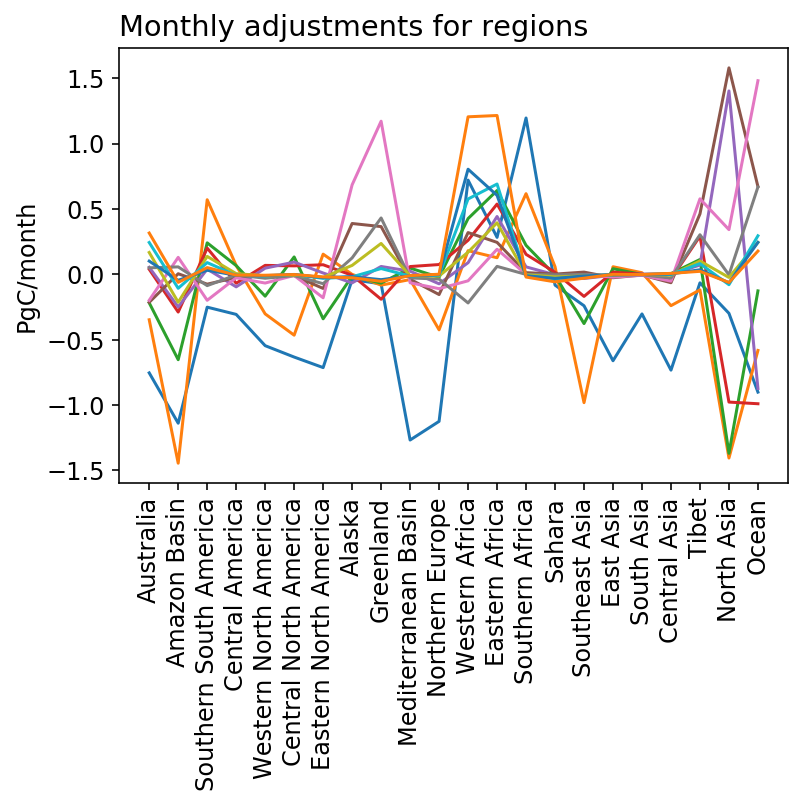

In [49]:
fig = plt.figure(figsize=[6, 4])
for i in range(12): 
    plt.plot(range(22), adjust_matrix[i])
    plt.xticks(range(22), region_names, rotation='vertical')
plt.title('Monthly adjustments for regions', loc='left')
plt.ylabel('PgC/month')
#plt.legend()

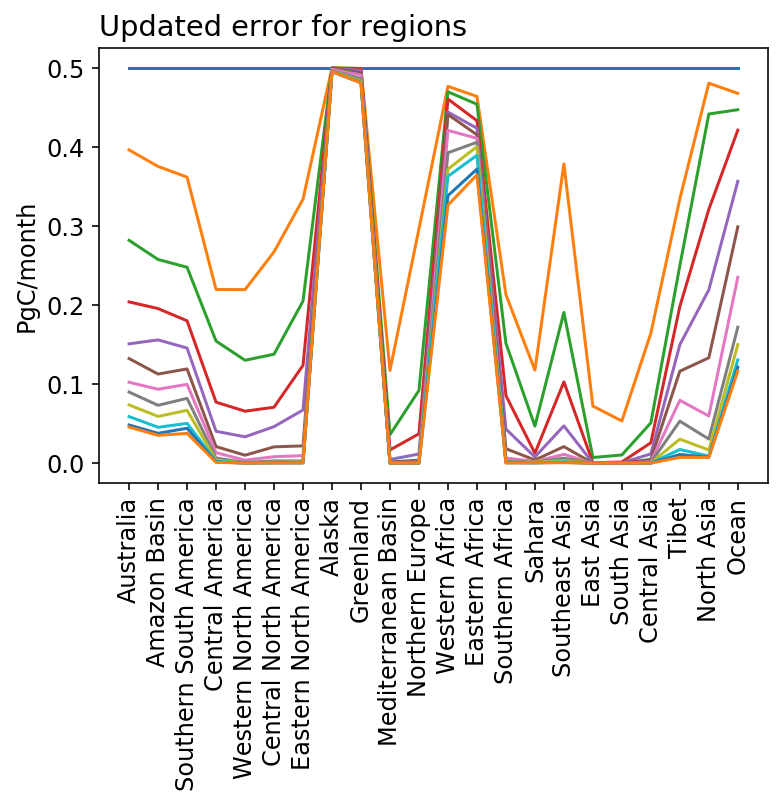

In [50]:
fig = plt.figure(figsize=[6, 4])
for i in range(12): 
    plt.plot(range(22), updated_err[i])
    plt.xticks(range(22), region_names, rotation='vertical')
plt.title('Updated error for regions', loc='left')
plt.ylabel('PgC/month')
fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/inversion_err_reduction.png', dpi = 300, bbox_inches='tight')


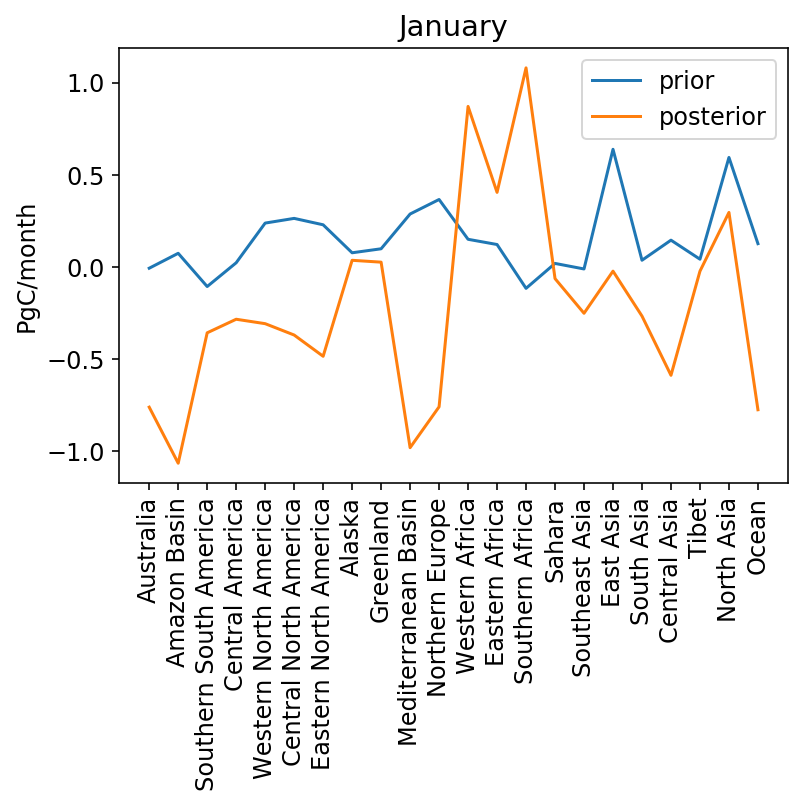

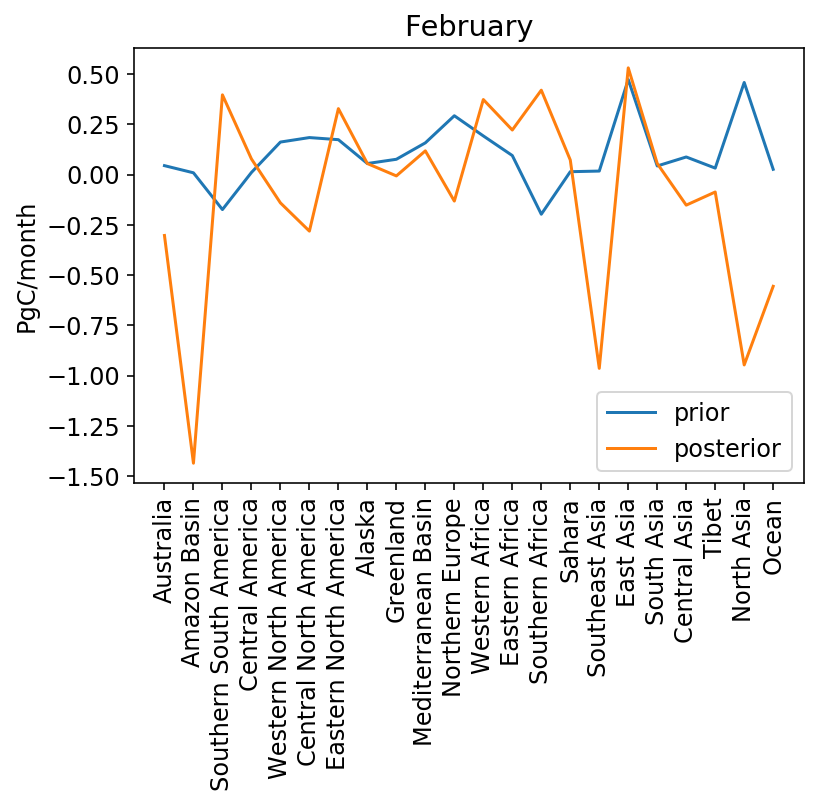

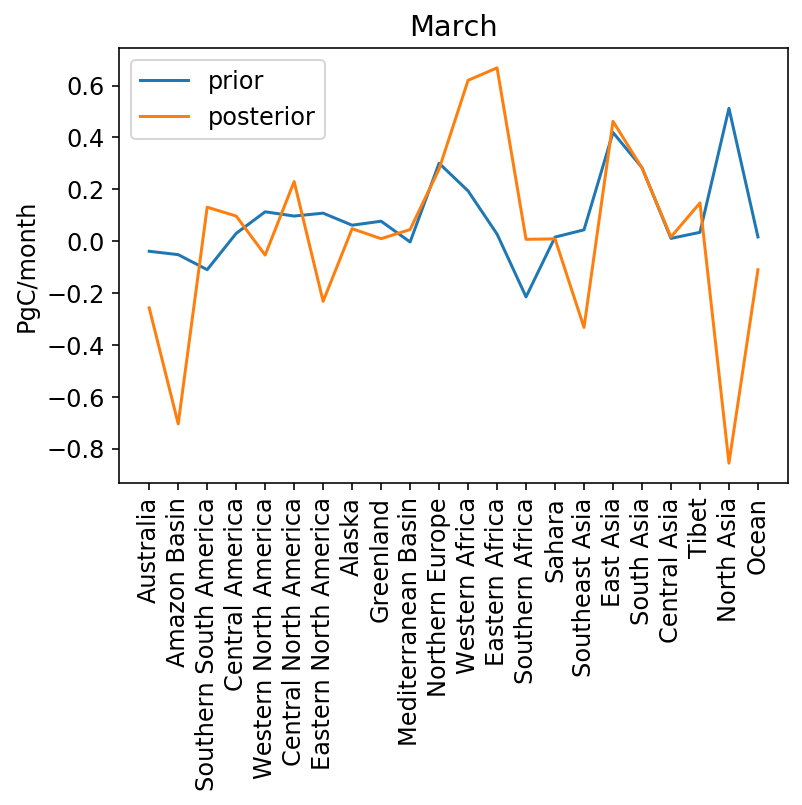

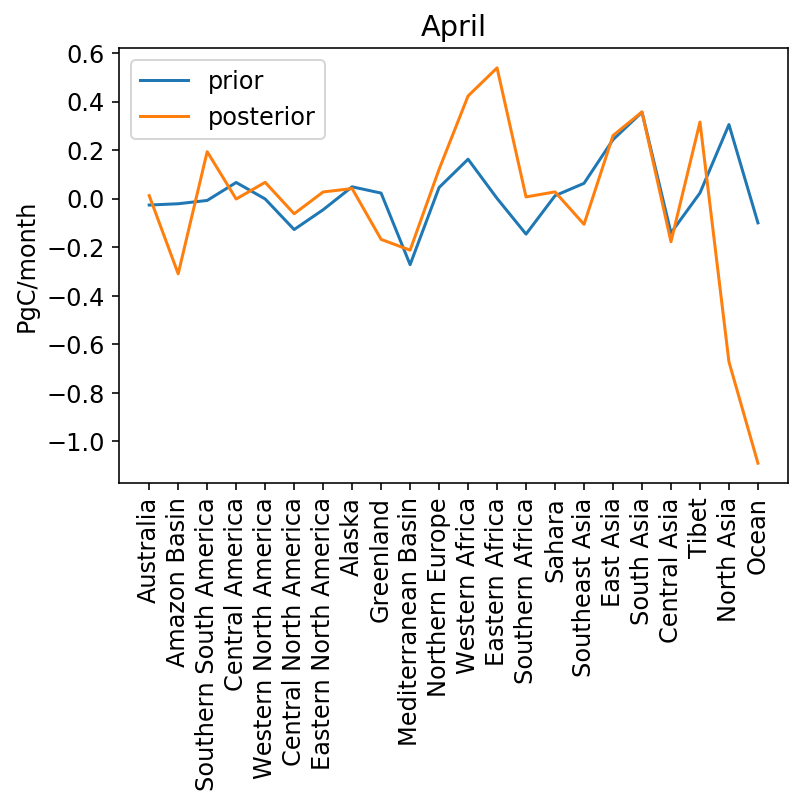

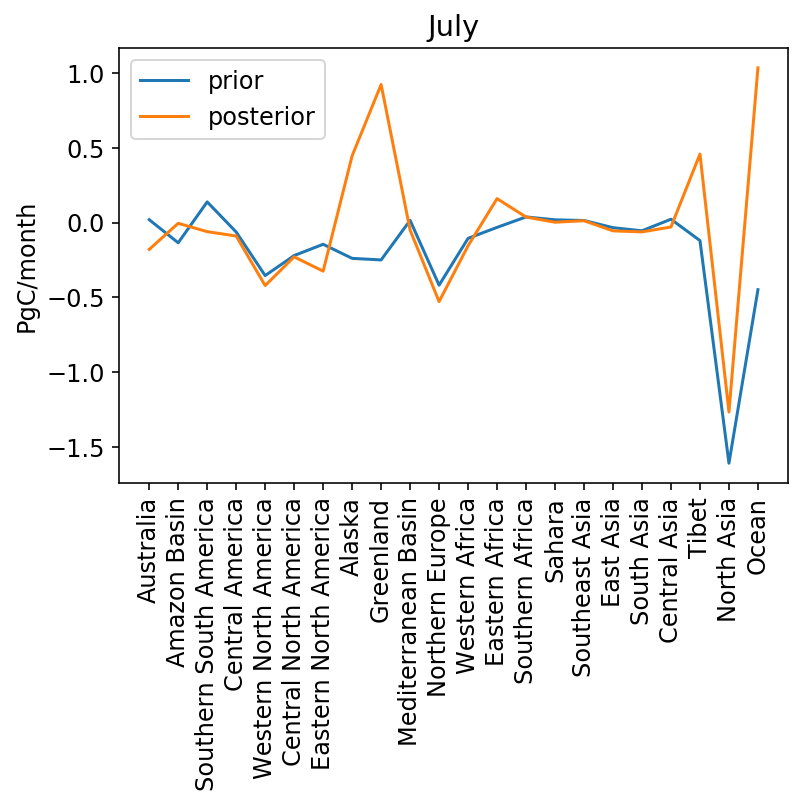

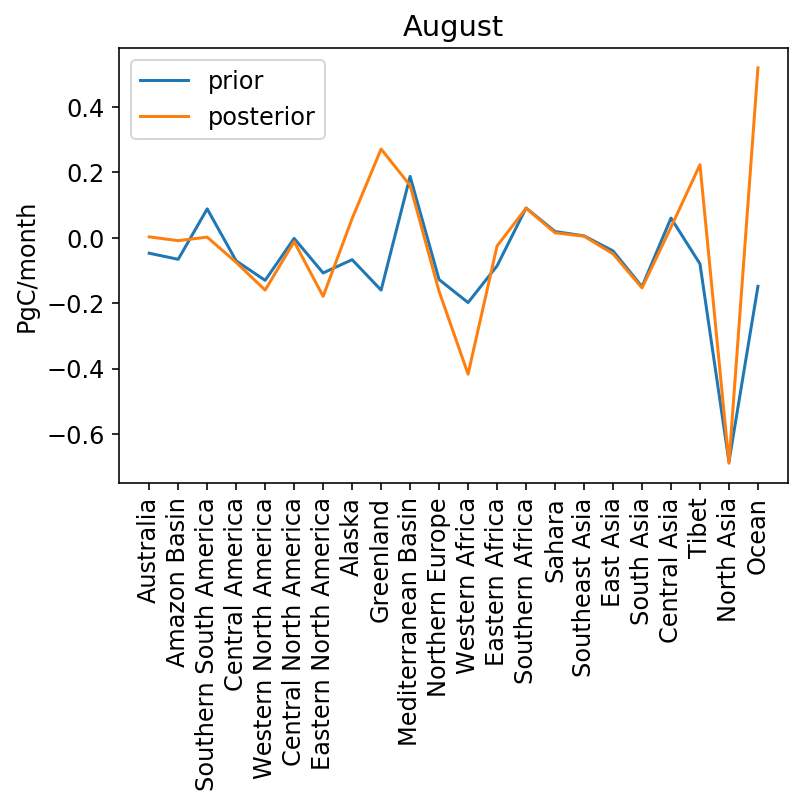

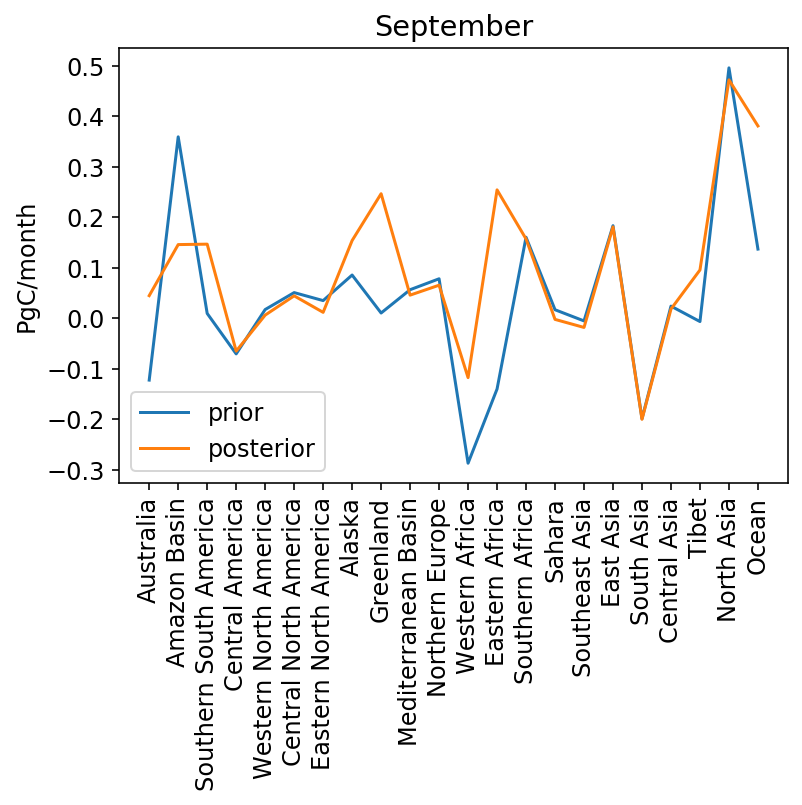

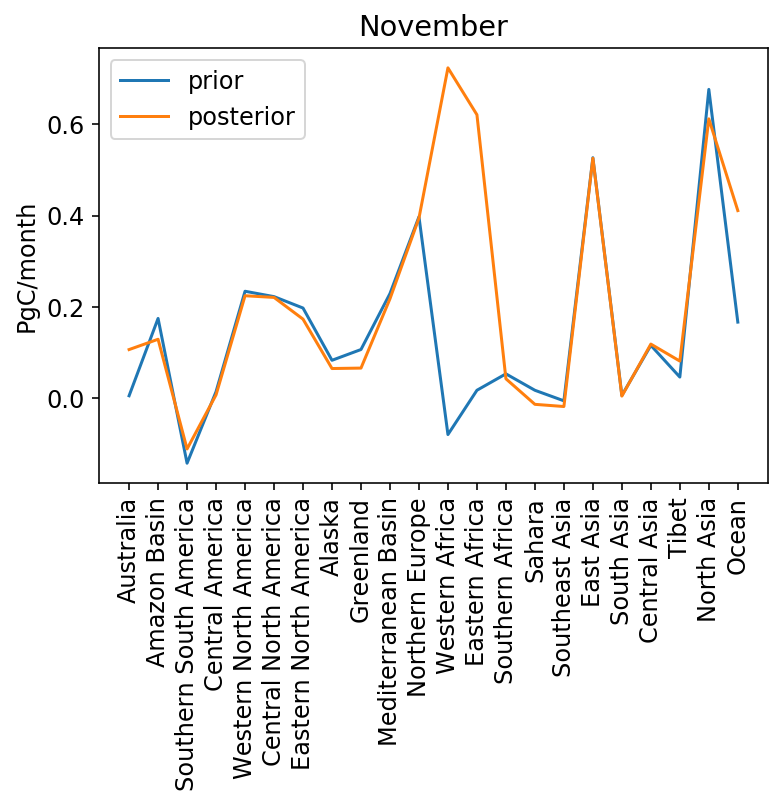

In [51]:
# check each month's update
for i in range(12):
    fig = plt.figure(figsize=[6, 4])
    plt.plot(range(1,23), monthly_net_flux[i,:], label = 'prior')
    plt.plot(range(1,23), monthly_net_flux[i,:] + adjust_matrix[i,:], label = 'posterior')
    plt.xticks(range(1,23), region_names, rotation='vertical')
    plt.title(long_name_of_month(i+1))
    plt.ylabel('PgC/month')
    plt.legend()

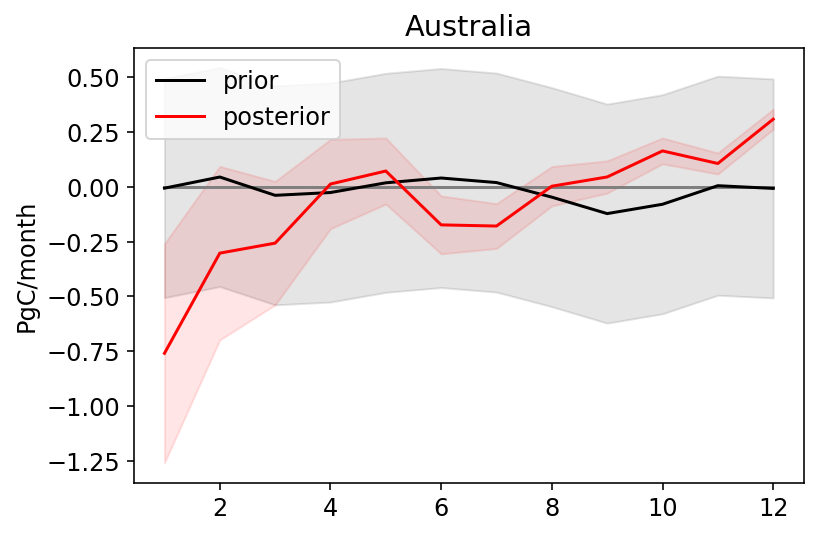

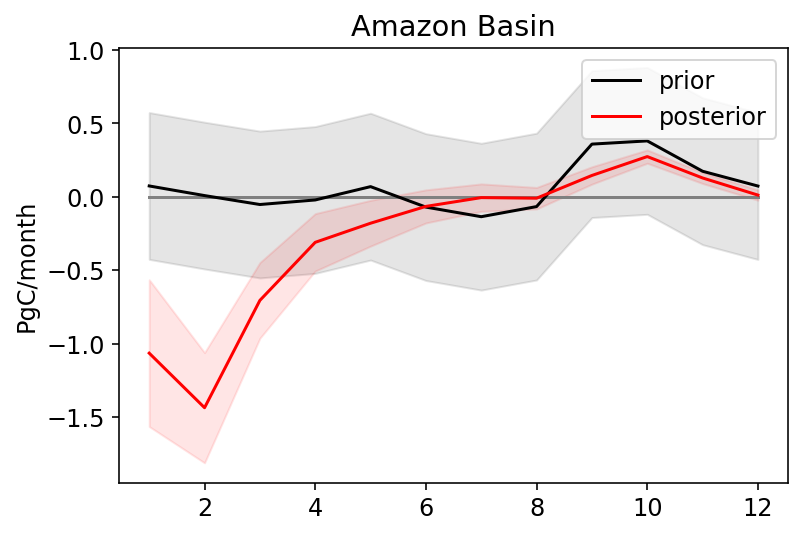

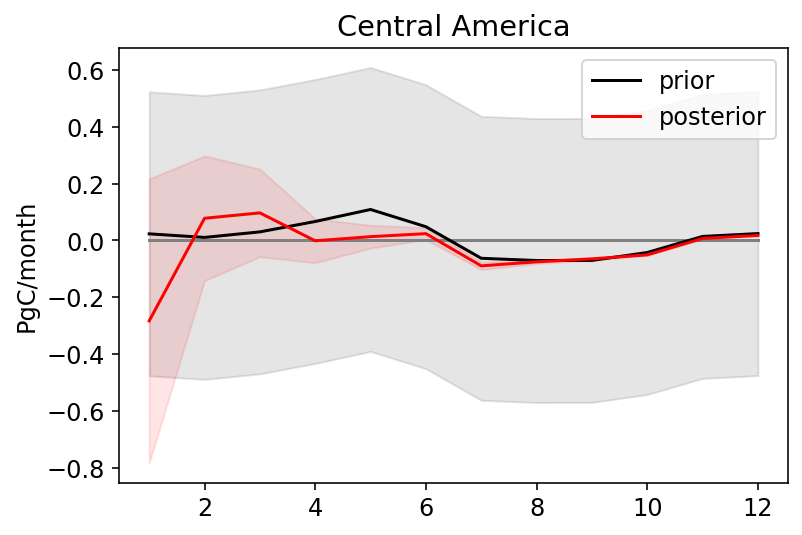

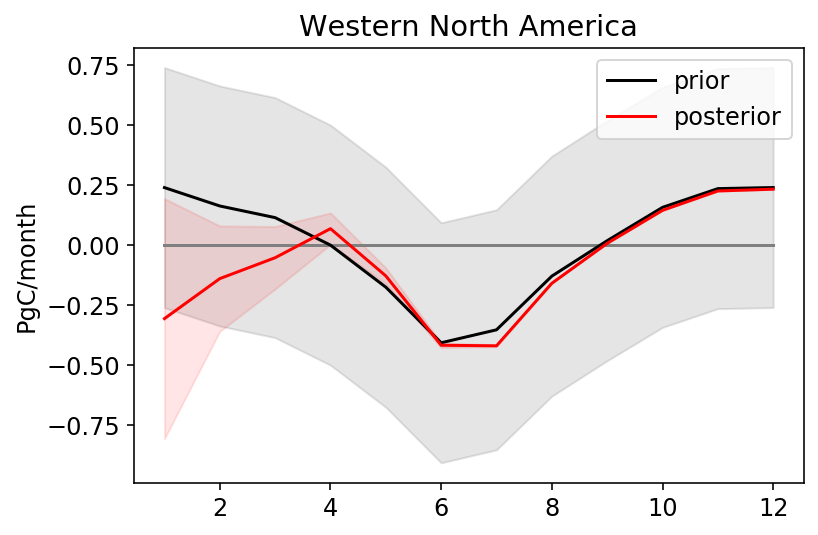

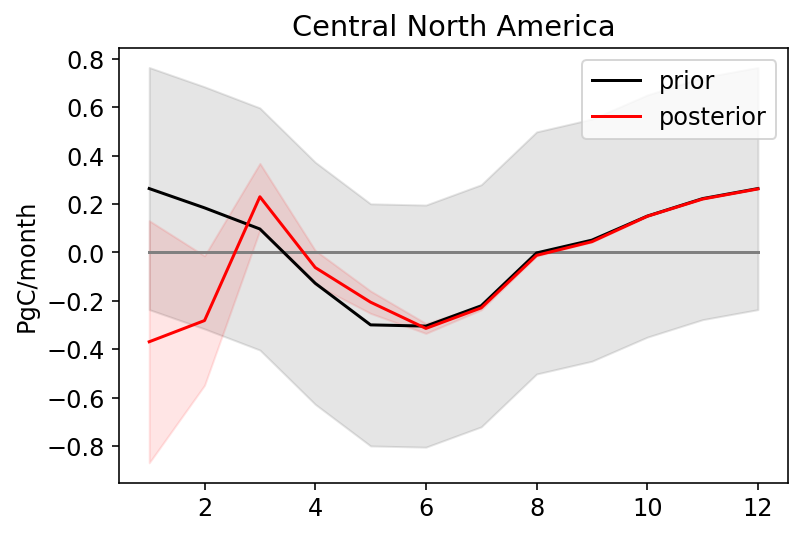

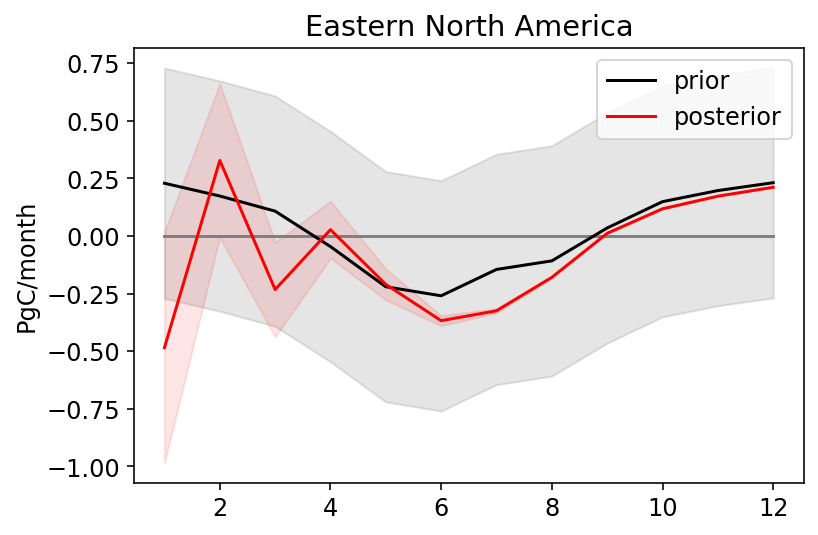

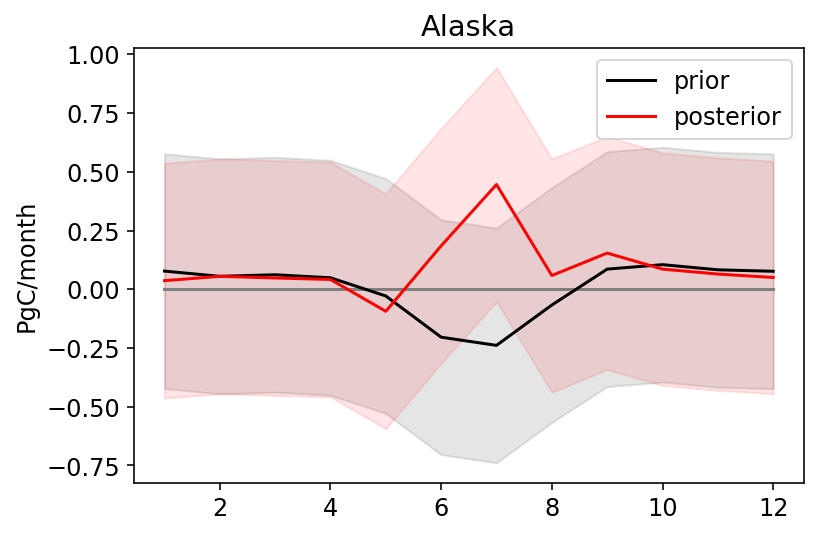

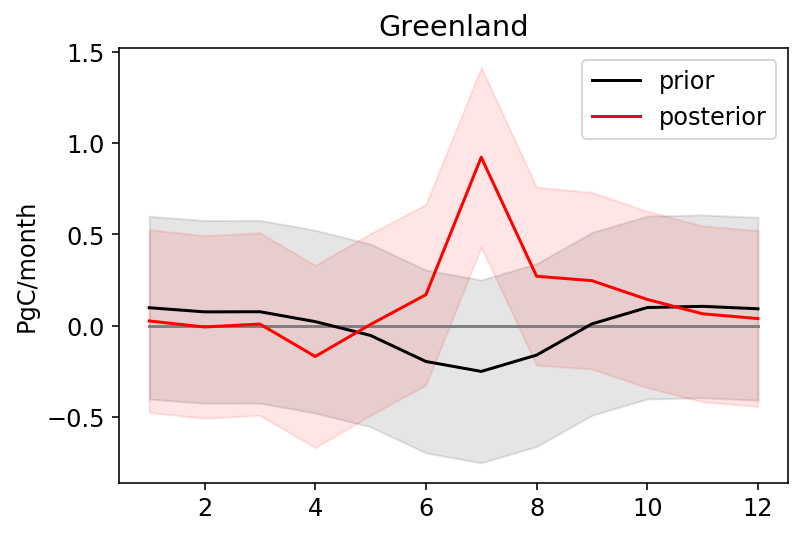

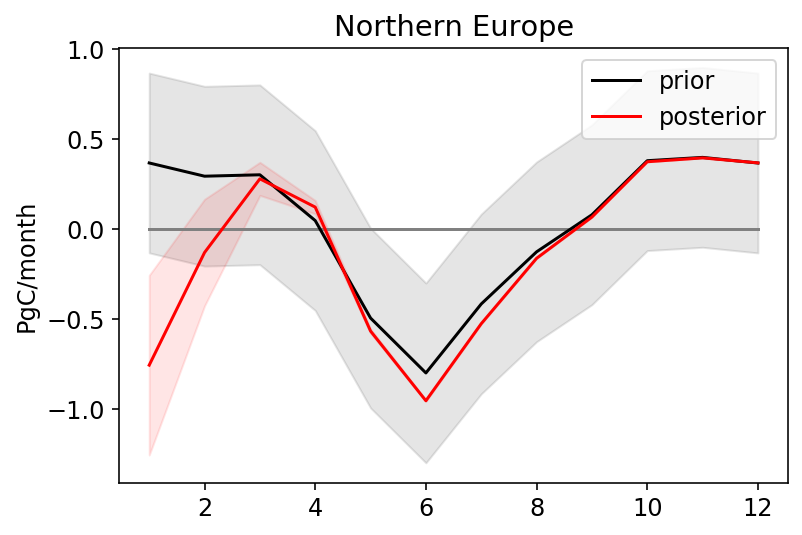

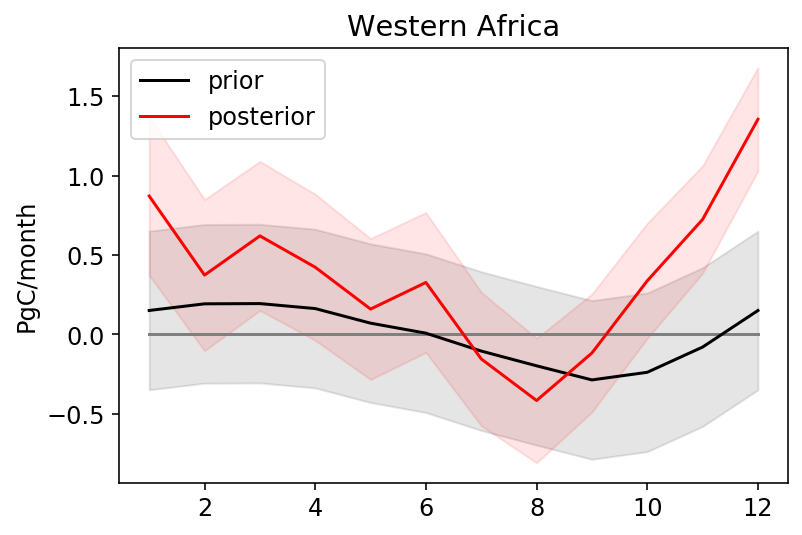

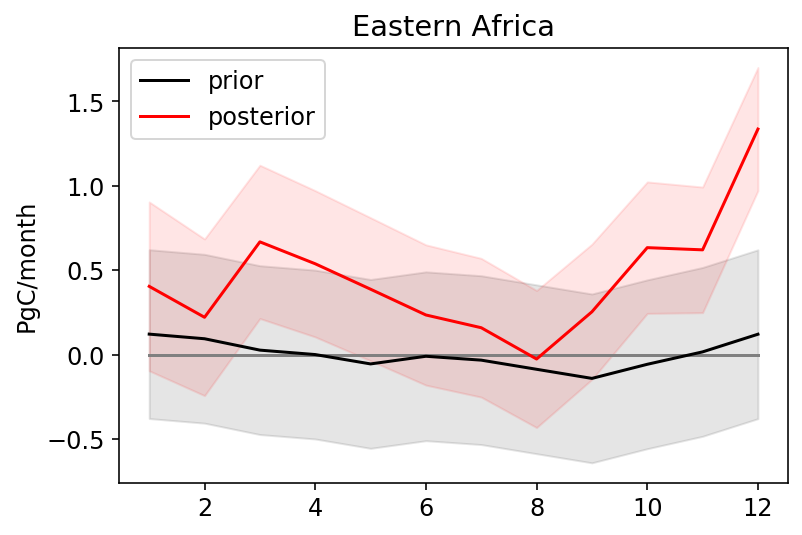

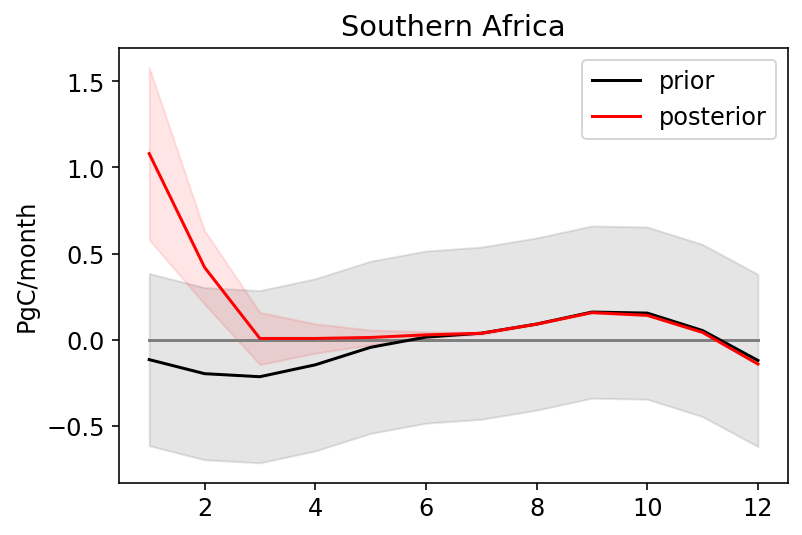

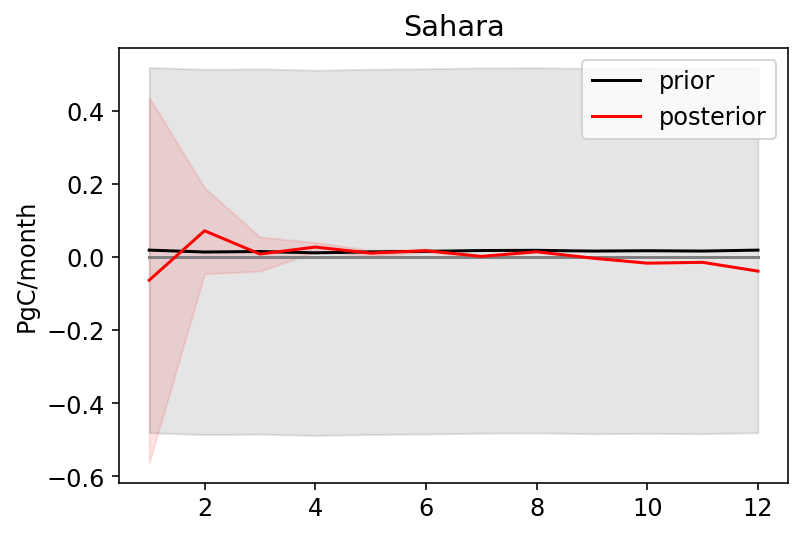

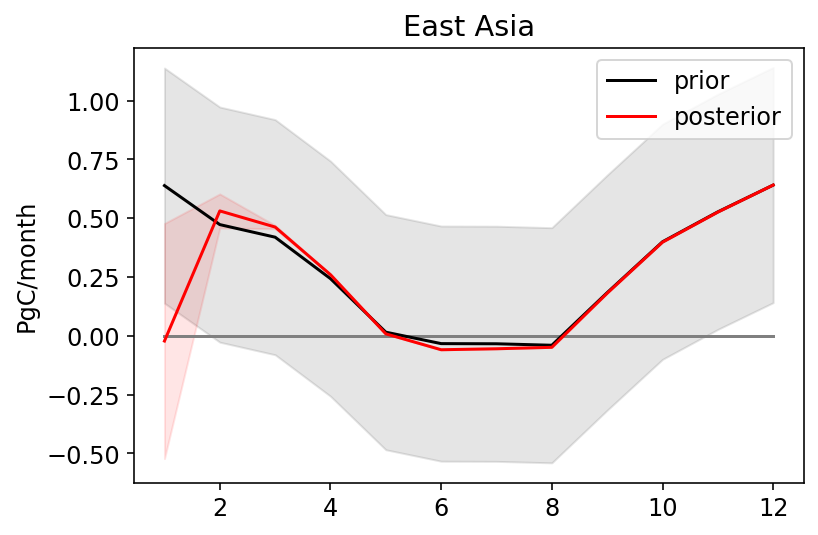

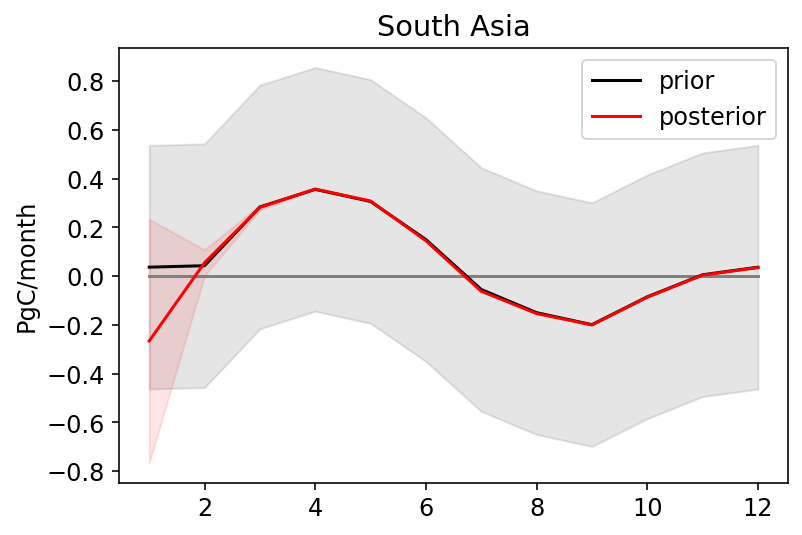

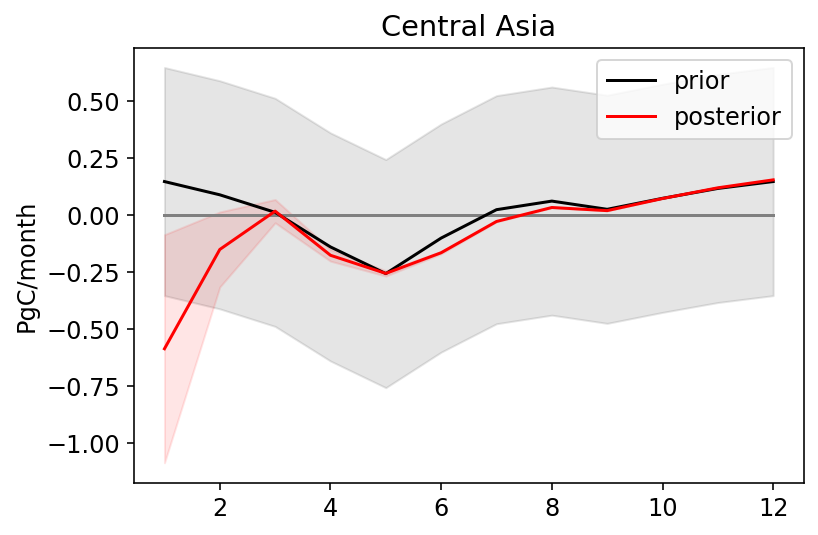

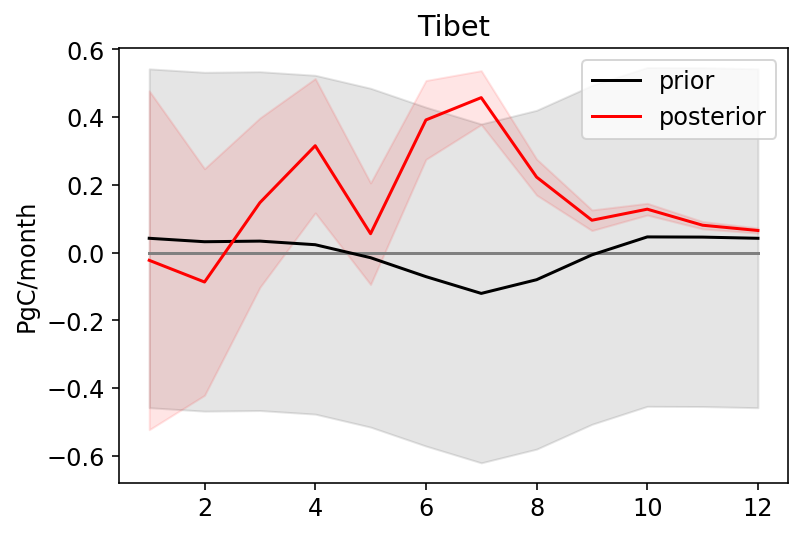

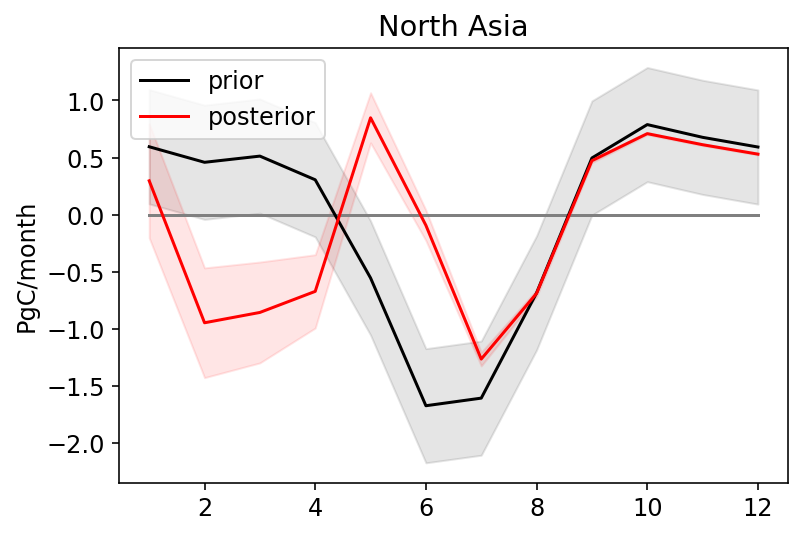

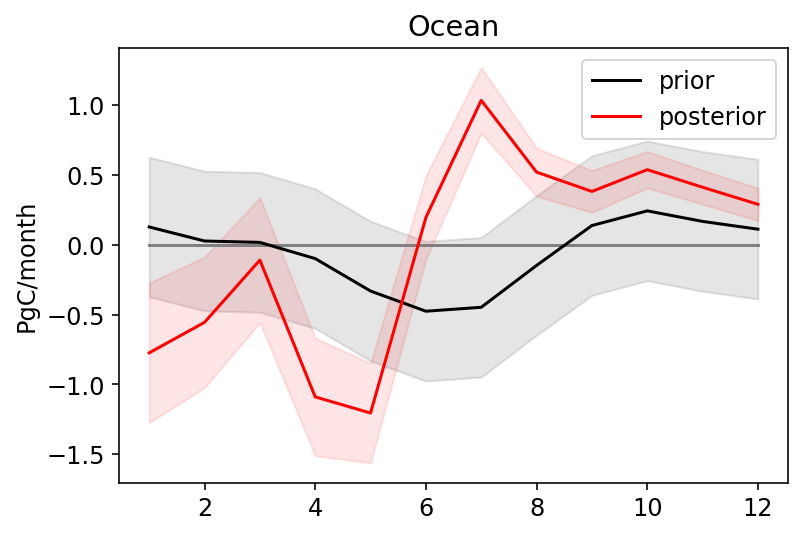

In [52]:
# check each region's update
for i in range(22):
    fig, ax = plt.subplots()
    x = range(1,13)
    y = monthly_net_flux[:,i]
    ax.plot(x, np.zeros(12), color = 'grey')
    ax.plot(x, y, label = 'prior', color = 'black')
    ax.fill_between(x, y-prior_err, y+prior_err, color = 'black', alpha = 0.1)
    
    updated = monthly_net_flux[:,i] + adjust_matrix[:,i]
    ax.plot(x, updated, label = 'posterior', color = 'r')
    ax.fill_between(x, updated-updated_err[:,i], updated+updated_err[:,i], color='r', alpha=.1)
    
    plt.title(region_names[i])
    plt.ylabel('PgC/month')
    plt.legend()
    
    fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/inversion_'+str(i)+'.png', dpi = 300)


In [53]:
fig, axs = plt.subplots(3,4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(12):
    x = range(1,13)
    y = monthly_net_flux[:,i]
    axs[i].plot(x, np.zeros(12), color = 'grey')
    axs[i].plot(x, y, label = 'prior', color = 'black')
    axs[i].fill_between(x, y-prior_err, y+prior_err, color = 'black', alpha = 0.1)
    
    updated = monthly_net_flux[:,i] + adjust_matrix[:,i]
    axs[i].plot(x, updated, label = 'posterior', color = 'r')
    axs[i].fill_between(x, updated-updated_err[:,i], updated+updated_err[:,i], color='r', alpha=.1)
    axs[i].set_title(region_names[i])
    
axs[0].set_ylabel('PgC/month')
axs[4].set_ylabel('PgC/month')
axs[8].set_ylabel('PgC/month')
axs[0].legend()

axs[8].set_xlabel('month')
axs[9].set_xlabel('month')
axs[10].set_xlabel('month')
axs[11].set_xlabel('month')

fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/inversion_regions1.png', dpi = 300)


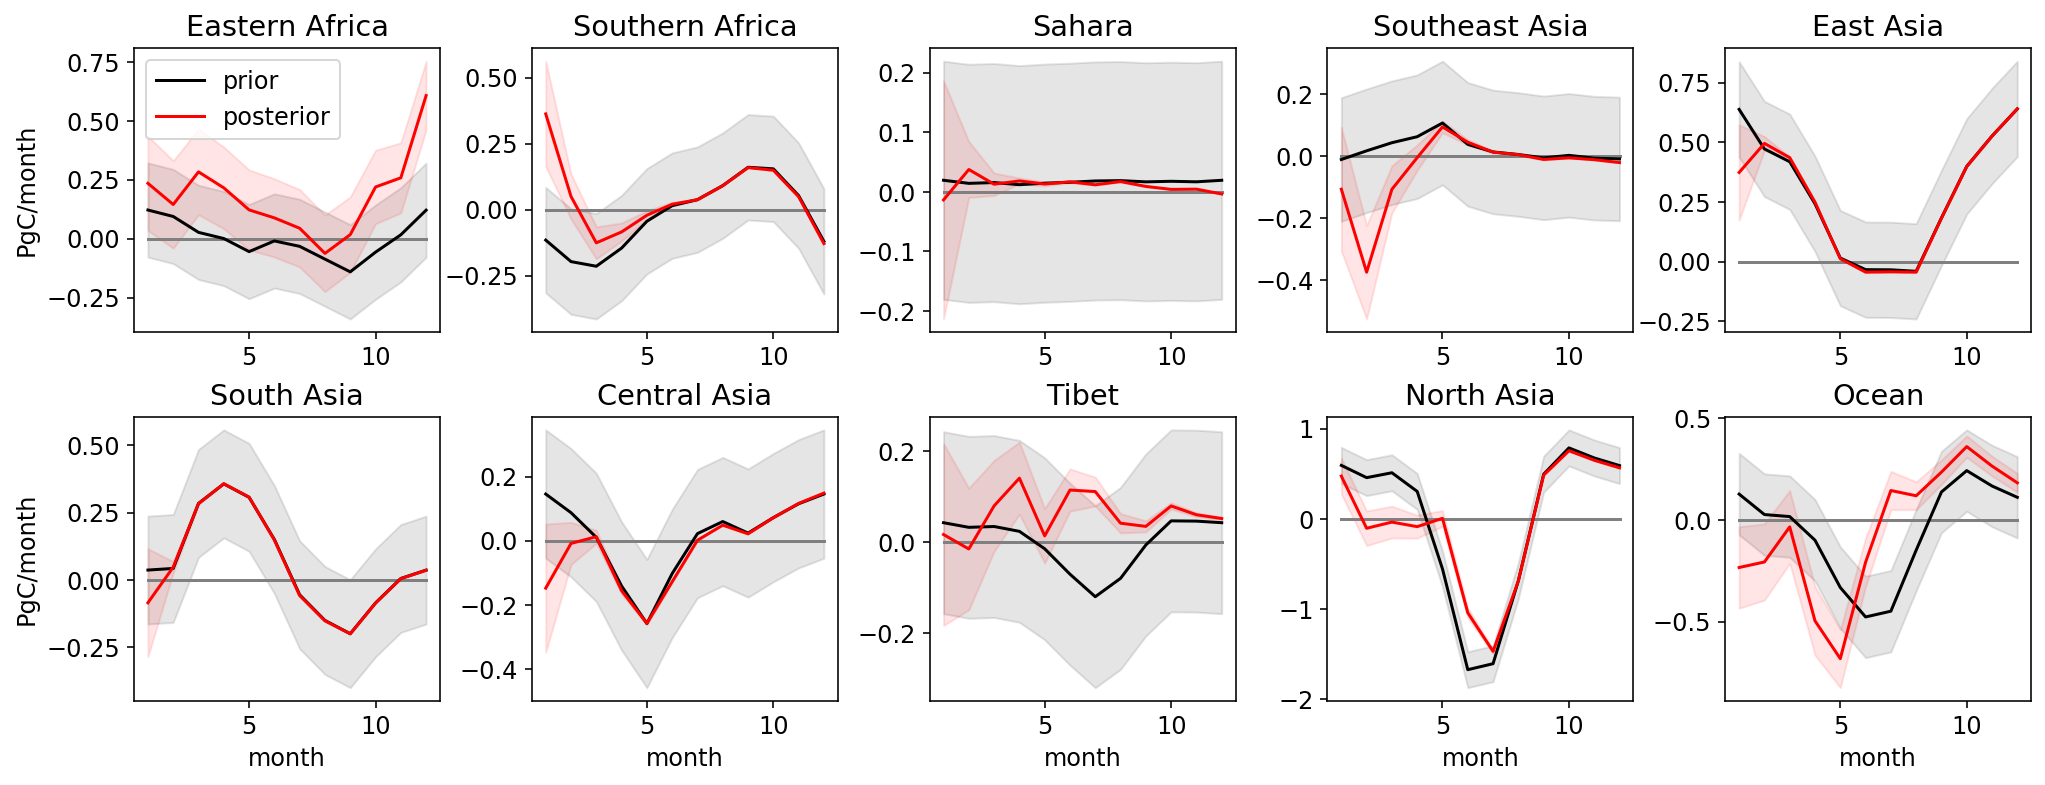

In [16]:
fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(10):
    x = range(1,13)
    imonth = i+12
    y = monthly_net_flux[:,imonth]
    axs[i].plot(x, np.zeros(12), color = 'grey')
    axs[i].plot(x, y, label = 'prior', color = 'black')
    axs[i].fill_between(x, y-prior_err, y+prior_err, color = 'black', alpha = 0.1)
    
    updated = monthly_net_flux[:,imonth] + adjust_matrix[:,imonth]
    axs[i].plot(x, updated, label = 'posterior', color = 'r')
    axs[i].fill_between(x, updated-updated_err[:,imonth], updated+updated_err[:,imonth], color='r', alpha=.1)
    axs[i].set_title(region_names[imonth])
    
axs[0].set_ylabel('PgC/month')
axs[5].set_ylabel('PgC/month')
axs[0].legend()

axs[5].set_xlabel('month')
axs[6].set_xlabel('month')
axs[7].set_xlabel('month')
axs[8].set_xlabel('month')
axs[9].set_xlabel('month')

fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/inversion_regions2.png', dpi = 300)

